In [3]:
%%time

%pip install -U tornado
%pip install "dask[complete]"

import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import codecs
from tqdm import tqdm
import pickle
from sklearn import preprocessing
import pandas as pd
import random as r
from sklearn.svm import SVC  # Import the Support Vector Machine classifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
CPU times: user 1.54 s, sys: 442 ms, total: 1.99 s
Wall time: 6.33 s


In [2]:
# Defining the root directory where your .asm files are stored
root_directory = os.path.expanduser("~/Documents/extracted_files/test")  # Update the path as needed

# Initialize a list to store .asm file paths and their contents
asm_files = []

# os.walk --> Recursively search for .asm files in the subdirectories within subdirectories
for dirpath, dirnames, filenames in os.walk(root_directory):
    for filename in filenames:
        if filename.endswith(".asm"):
            asm_path = os.path.join(dirpath, filename)
            with open(asm_path, 'r', encoding='utf-8', errors='ignore') as file:
                asm_content = file.read()
                asm_files.append((asm_path, asm_content))



In [4]:
def firstprocess():
    #The prefixes tells about the segments that are present in the asm files
    #There are 450 segments(approx) present in all asm files.
    #this prefixes are best segments that gives us best values.
    #https://en.wikipedia.org/wiki/Data_segment
    
    prefixes = ['.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    #this are opcodes that are used to get best results
    #https://en.wikipedia.org/wiki/X86_instruction_listings
    
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    #best keywords that are taken from different blogs
    #keywords = ['.dll','std::',':dword']
    #Below taken registers are general purpose registers and special registers
    #All the registers which are taken are best 
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("asmsmallfile.txt","w+")
#     file1.write("Filename,")    
    # Write headers to the file
    headers = ["Filename"] + prefixes + opcodes + registers
    file1.write(",".join(headers) + "\n")
    files = os.listdir('/home/dikshyant17/Documents/Major/extracted_files/test/sample')
    for f in files:
        #filling the values with zeros into the arrays
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
#         keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
#         opcodefile.write(f2+" ")
        # https://docs.python.org/3/library/codecs.html#codecs.ignore_errors
        # https://docs.python.org/3/library/codecs.html#codecs.Codec.encode
        with codecs.open('/home/dikshyant17/Documents/Major/extracted_files/test/sample/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                # https://www.tutorialspoint.com/python3/string_rstrip.htm
                line=lines.rstrip().split()
                l=line[0]
                #counting the prefixs in each and every line
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                #counting the opcodes in each and every line
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                #counting registers in the line
                for i in range(len(registers)):
                    for li in line:
                        # we will use registers only in 'text' and 'CODE' segments
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                #counting keywords in the line
#                 for i in range(len(keywords)):
#                     for li in line:
#                         if keywords[i] in li:
#                             keywordcount[i]+=1
        #pushing the values into the file after reading whole file
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
#         for key in keywordcount:
#             file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


In [5]:
firstprocess()

In [8]:
# asmoutputfile.csv(output genarated from the above two cells) will contain all the extracted features from .asm files
# we will use this file directly
Y=pd.read_csv("/home/dikshyant17/Documents/Major/final.csv")
Y.columns=['ID','Class']
dfasm=pd.read_csv('asmsmallfile.csv')
result_asm=pd.merge(dfasm,Y,on='ID',how='left')
result_asm.head()

,ID,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,.tls:,...,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class
0,0a5f0b6e561eb8c844d80378b68cf73c686416e98348f6...,197746,0,0,0,0,0,0,601,0,...,11118,17155,28342,11817,12269,16826,10746,7360,0,NaN
1,0a4e767ee27b33d4e1dad30ffe016a03a2a8b052391fed...,258450,0,0,0,0,0,0,568,0,...,15436,23069,46740,14649,15721,25768,10623,8867,0,NaN
2,0a7f9a4a2ff6257feb79223e3432cef859eda0b8e57384...,120575,0,0,0,0,0,0,76938,0,...,6963,10721,25361,7713,7699,10850,5435,4341,0,NaN
3,0a1bb1a2004b1405b80cfcb2249c2cfab85aaed1cad4eb...,342277,0,0,0,0,0,0,102598,0,...,20618,30745,59535,21624,21794,32686,15569,12643,0,NaN
4,0a1ee17e9f99fe5c56130431f0598e30edde7f9b3a384e...,260302,0,0,0,0,0,0,33335,0,...,17106,23659,59891,15200,17267,22795,9923,7683,0,NaN


## ASM FILE SIZES AS A FEATURE

In [11]:
# file sizes as a feature

files=os.listdir('/home/dikshyant17/Documents/Major/extracted_files/test/sample/')
filenames=Y['ID'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('/home/dikshyant17/Documents/Major/extracted_files/test/sample/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
asm_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (asm_size_byte.head())

                                                  ID       size  \
0  0a5f0b6e561eb8c844d80378b68cf73c686416e98348f6...   7.125170   
1  0a1bb1a2004b1405b80cfcb2249c2cfab85aaed1cad4eb...  15.835052   
2  0a4e767ee27b33d4e1dad30ffe016a03a2a8b052391fed...   9.362388   
3  0a7f9a4a2ff6257feb79223e3432cef859eda0b8e57384...   7.117259   
4  0a1ee17e9f99fe5c56130431f0598e30edde7f9b3a384e...  10.768058   

            Class  
0  SnakeKeylogger  
1  SnakeKeylogger  
2  SnakeKeylogger  
3           njrat  
4            Loki  


## Distribution of asm files

<IPython.core.display.Javascript object>


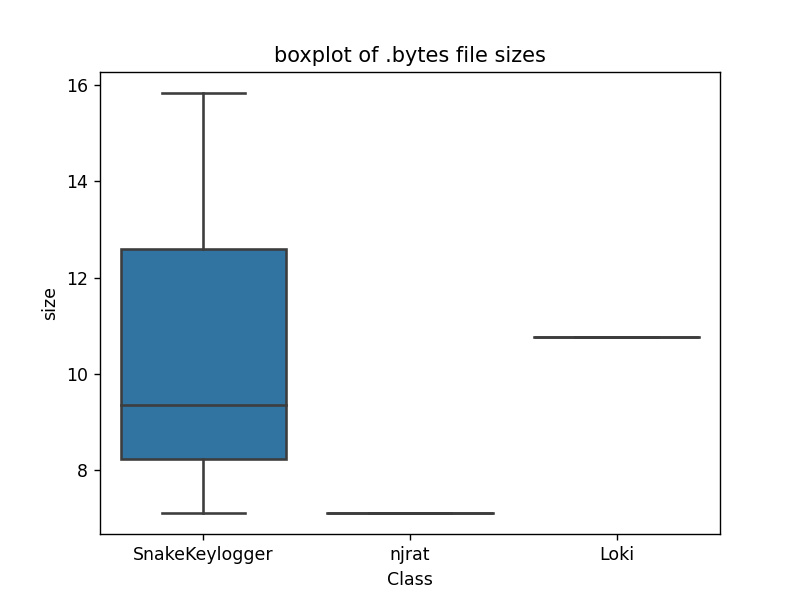

In [13]:
#boxplot of asm files
ax = sns.boxplot(x="Class", y="size", data=asm_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

In [14]:
# add the file size feature to previous extracted features
print(result_asm.shape)
print(asm_size_byte.shape)
result_asm = pd.merge(result_asm, asm_size_byte.drop(['Class'], axis=1),on='ID', how='left')
result_asm.head()

(5, 49)
(5, 3)


,ID,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,.tls:,...,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class,size
0,0a5f0b6e561eb8c844d80378b68cf73c686416e98348f6...,197746,0,0,0,0,0,0,601,0,...,17155,28342,11817,12269,16826,10746,7360,0,NaN,NaN
1,0a4e767ee27b33d4e1dad30ffe016a03a2a8b052391fed...,258450,0,0,0,0,0,0,568,0,...,23069,46740,14649,15721,25768,10623,8867,0,NaN,NaN
2,0a7f9a4a2ff6257feb79223e3432cef859eda0b8e57384...,120575,0,0,0,0,0,0,76938,0,...,10721,25361,7713,7699,10850,5435,4341,0,NaN,NaN
3,0a1bb1a2004b1405b80cfcb2249c2cfab85aaed1cad4eb...,342277,0,0,0,0,0,0,102598,0,...,30745,59535,21624,21794,32686,15569,12643,0,NaN,NaN
4,0a1ee17e9f99fe5c56130431f0598e30edde7f9b3a384e...,260302,0,0,0,0,0,0,33335,0,...,23659,59891,15200,17267,22795,9923,7683,0,NaN,NaN


In [15]:
# we normalize the data each column 
result_asm = normalize(result_asm)
result_asm.head()

NameError: name 'normalize' is not defined